# A manually worked GP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

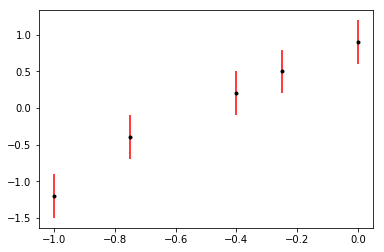

In [2]:
# We have some data with some uncertainty and we want to predict some other data
x = np.array([-1, -0.75, -0.4, -0.25, 0])
y = np.array([-1.2, -0.4, 0.2, 0.5, 0.9])
err = 0.3
plt.errorbar(x, y, yerr=err, linestyle="", marker=".", color="black", ecolor="red")

goal_x = np.array([0.1])

In [40]:
# We can define a covariance function that describes how similar points
# at different locations should be

# There are these two hyperparameters
max_covariance = 100
length_scale = 1

def covariance_function(x):
    xCol = np.expand_dims(x, 1)
    xRow = np.expand_dims(x, 0)
    basic_cov = max_covariance * np.exp(-(xRow - xCol)**2/(2*length_scale))
    data_err_cov = np.identity(len(x)) * err**2
    return (basic_cov + data_err_cov)


## Predict a single point

In [41]:
# We can build up the covariance matrix for the known data + the test data
# Also need a mean
mean = 0
cov_matrix = covariance_function(np.concatenate((x, goal_x)))

In [42]:
# We now have a mean and a covariance matrix - this is all we need to sample from a mv gaussian
# Our data y values are the samples in the first n dimensions of the mv gaussian
# We now need to take the sample for the final, test dimension.
# However, the probability for draws in that dimension depend on what we got for all the previous draws
# They are correlated
# We (I can't yet...) can do some matrix algebra to find what p(test_y_value | training_y_values)

cov_test_with_data = cov_matrix[-1 ,:-1]
cov_data_with_data = cov_matrix[:-1,:-1]
cov_test_with_test = cov_matrix[-1 , -1]

pred_y = np.dot(cov_test_with_data, np.matmul(np.linalg.inv(cov_data_with_data), y))
print(pred_y)

var_y = cov_test_with_test - np.dot(
    cov_test_with_data, np.matmul(
        np.linalg.inv(cov_data_with_data), cov_test_with_data))
print(var_y)

1.0059846242561221
0.29307019346266827


## Predict a large numpy of data points

In [43]:
goals = np.linspace(-1.5, 0.3, num=50)

cov_matrix = covariance_function(np.concatenate((x, goals)))
cut = len(x)
cov_test_with_data = cov_matrix[cut:,:cut]
cov_data_with_data = cov_matrix[:cut,:cut]
cov_test_with_test = cov_matrix[cut:,cut:]

pred_ys = np.matmul(cov_test_with_data, np.matmul(np.linalg.inv(cov_data_with_data), y))

var_ys = cov_test_with_test - np.matmul(cov_test_with_data, 
        np.matmul(np.linalg.inv(cov_data_with_data), cov_test_with_data.T))
var_ys = np.diag(var_ys) # off diagonals are the covariance which we don't care about

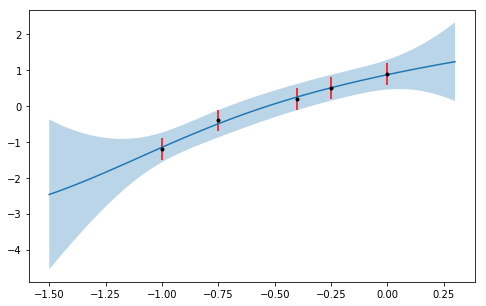

In [44]:
_, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, yerr=err, linestyle="", marker=".", color="black", ecolor="red")

ax.plot(goals, pred_ys)
ax.fill_between(goals, pred_ys - np.sqrt(var_ys), pred_ys + np.sqrt(var_ys), alpha=0.3)

## Function spaces

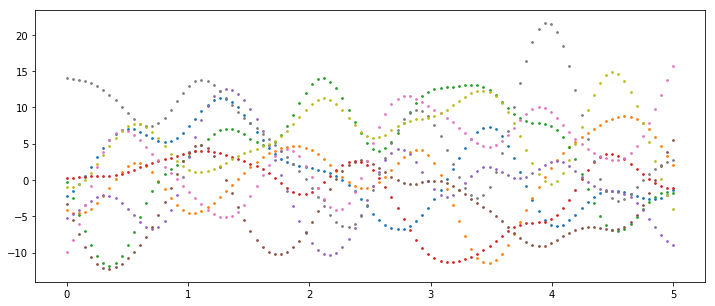

In [128]:
# Lets assume we just have a set of x variables
x = np.linspace(0, 5, 100)

# We also have a covariance function and mean function + hyperparams
max_covariance = 40
length_scale = 0.1

def fs_covariance_function(x):
    xCol = np.expand_dims(x, 1)
    xRow = np.expand_dims(x, 0)
    basic_cov = max_covariance * np.exp(-(xRow - xCol)**2/(2*length_scale))
    return basic_cov

def fs_mean_function(x):
    return np.zeros_like(x)
# We can now generate a covariance matrix and mean vector
cov_matrix = fs_covariance_function(x)
mean_vector = fs_mean_function(x)

# Those fully specify a multivariate gaussian distribution of the same dim as our X
# A draw from these returns our potential Y data
# Currently that Y data is unconstrained (we don't have any training data) except for
# the constraints by the hyperparams.
# e.g. increasing the max_cov increases the range of the function
# increasing the length scale decreases the rate at which the function varies
_, ax = plt.subplots(figsize=(12, 5))
for i in range(9):
    y_pred = np.random.multivariate_normal(mean_vector, cov_matrix)
    ax.scatter(x, y_pred, s=3)

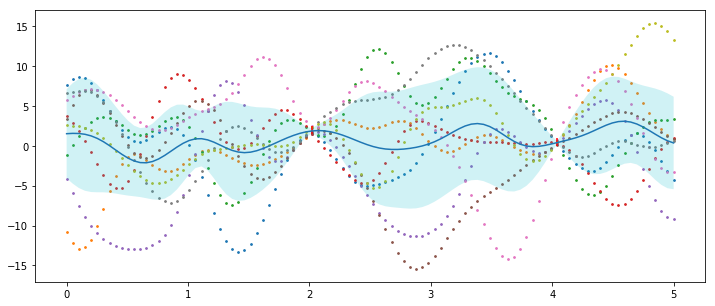

In [129]:
# We can add a couple of observations to constrain the valid functions.
# Let's say that we know that at x = 2 our value is 2 and at x = 4 it is 0, in both cases +/- 0.5
x = np.linspace(0, 5, 100)
idx_2 = np.searchsorted(x, 2)
idx_4 = np.searchsorted(x, 4)

_, ax = plt.subplots(figsize=(12, 5))
ax.errorbar([x[idx_2], x[idx_4]], [2, 0.5], yerr=0.5, color="red", ls="")
num_runs = 9
mean = np.zeros((num_runs, len(x)))
for i in range(num_runs):
    while True:
        y_pred = np.random.multivariate_normal(mean_vector, cov_matrix)
        # This is a simplification. We should prefer things closer to the center and not have a hard cutoff
        # I'm not sure if p(accept) should be a gaussian, in which case we would be biased 
        # closer to the mean function.
        if 1.5 < y_pred[idx_2] < 2.5 and 0 < y_pred[idx_4] < 1:
            break
    ax.scatter(x, y_pred, s=3)
    mean[i] = y_pred

    
# We can match out observations by waiting until be have a mv_gaussian that hits them. This tightly
# constrains points near to our observation and weakly constrains points further away.
# You can imagine that with enough "gates" (data points) to go through, all locations are well constrained.
# This is fantastically slow way of sampling from a mv_gauss with constraints. The linear algebra
# I used above and don't understand is just a fast way of sampling y* given y and a covariance matrix.

# But this is all GP is - given some hyperparams (description of how func should vary) and some
# data constraints (description of gates the func should pass through) we can find all possible
# funcs that satisfy these two criteria.
# By finding all possible solutions, we can then get the mean value of those functions at each point
# We can also find the dispersion in the possible functions and that is the variance.
# Note that above we got the variance by using more linear algebra I don't understand yet. In the same way 
# that you can use the covariance matrix to sample y* you can use it to find the dispersion of possible
# vals at that x.

func_mean = np.mean(mean, axis=0)
func_std = np.std(mean, axis=0)
ax.plot(x, func_mean)
ax.fill_between(x, func_mean - func_std, func_mean + func_std, alpha=0.2)

# Play